# Day 11 SVM(Support Vector Machine)
属于有监督学习算法,即可用于分类,也可用于回归.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

## 由来
对于贝叶斯分类,是先对每个类进行了随机分布的假设，然后建模,并用生成的模型估计新数据点的标签,属于**生成分类**方法.
<br>而SVM属于**判别分类**方法,其不再为每类数据建模，而是用一条分割线(二维空间中的直线或曲线)或者流形体
(多维空间中的曲线、曲面等概念的推广)将各种类型分割开。

<br>下面用一个简单的分类示例来演示，其中两种类型的数据可以被清晰地分割开:

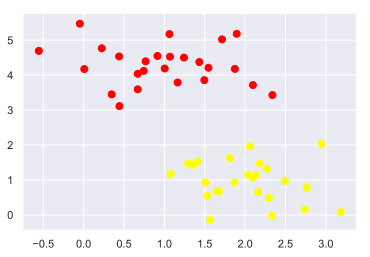

In [2]:
from sklearn.datasets.samples_generator import make_blobs
# make_blobs: 
'''make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1.0, 
                    center_box=(-10.0, 10.0), shuffle=True, random_state=None)
Returns:
X : array of shape [n_samples, n_features]
    The generated samples.
y : array of shape [n_samples]
    The integer labels for cluster membership of each sample: 样本数据集的标签,标识属于哪个cluster
'''
X, y = make_blobs(n_samples=50, centers=2,
                               random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

如果尝试画一条将数据分成两部分的直线，这样就构成了一个分类模型. 但很明显,这样的线有无数条!
<br>做出其中3条如下:

(-1, 3.5)

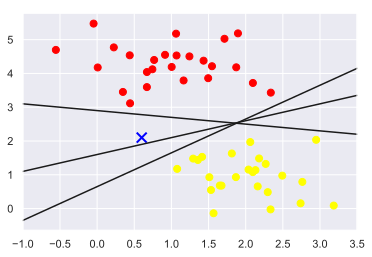

In [3]:
xfit = np.linspace(-1, 3.5)
#Signature: np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') # s : scalar or array_like, shape (n, )
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)
for k, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, k * xfit + b,'-k')
plt.xlim(-1, 3.5)

假如'x'点(blue点)为新的数据点,那么根据这3条不同的分界线,'x'点则分配到不同的标签.
<br>支持向量机提供了改进这个问题的方法，它直观的解释是:不再画一条细线来区分类 型，而是画一条到最近点边界、有宽度的线条。

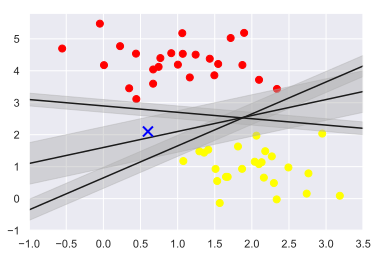

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for k, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.65), (-0.2, 2.9, 0.2)]:
    yfit = k * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)
plt.xlim(-1, 3.5);
# plt.fill_between?

在支持向量机中，选择边界最大的那条线是模型最优解。支持向量机其实就是一个**边界最大化评估器。**

## 拟合支持向量机
用 Scikit-Learn 的支持向量机分类器在数据上训练一个SVM 模型。这里用一个线性核函数，并将参数 C 设置为一个很大的数

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
# C: float, optional (default=1.0), Penalty parameter C of the error term.
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

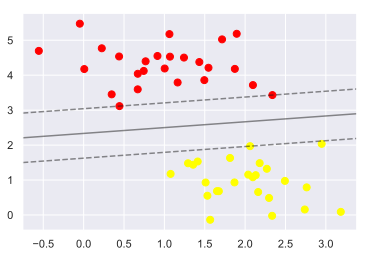

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True): 
    """画二维SVC的决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 画决策边界和边界
    ax.contour(X, Y, P, colors='k',levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=300, linewidth=1, facecolors='none');
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

这就是两类数据间隔最大的分割线。你会发现有一些点正好就在边界线上.这些点是拟合的关键支持点，被称为**支持向量**，
<br>支持向量机算法也因此得名。在 Scikit-Learn 里面，**支持向量的坐标存放在分类器的 support_vectors_ 属性中:**

In [7]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

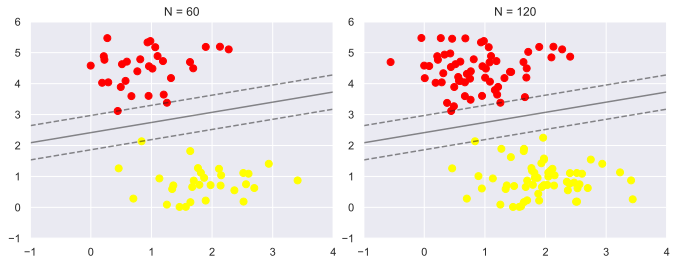

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

**分类器能够成功拟合的关键因素，就是这些支持向量的位置——任何在正确分类一侧远离边界线的点都不会影响拟合结果!
<br>这种对远离边界的数据点不敏感的特点正是 SVM 模型的优点之一。**

In [9]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## 超越线性边界:核函数SVM模型
在 SVM 模型中，我们可以沿用同样的思路。为了应用核函数，引入一些非线性可分的数据

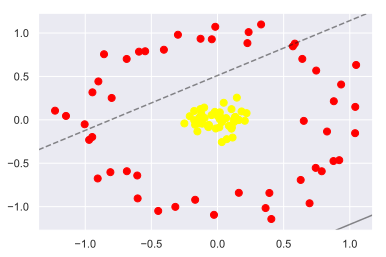

In [10]:
from sklearn.datasets.samples_generator import make_circles
#make_circles: Make a large circle containing a smaller circle in 2d.
X, y = make_circles(100, factor=.1, noise=.1)
clf = SVC(kernel='linear').fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

显然，这里需要用非线性判别方法来分割数据
<br>例如，一种简单的投 影方法就是计算一个以数据圆圈(middle clump)为中心的**径向基函数:**

In [11]:
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

增加新维度之后，数据变成了线性可分状态。如果现在画一个分割平面，例如 r = 0.7，即可将数据分割。
<br>我们还需要仔细选择和优化投影方式,通常，选择基函数比较困难，我们需要让模型自动指出 最合适的基函数。
<br>一种策略是计算基函数在数据集上**每个**点的变换结果，让 SVM 算法从所有结果中筛选出 最优解。这种基函数变换方式被称为**核变换**，是基于每对数据点之间的相似度(或者核函 数)计算的。这种策略的问题是，如果将 N 个数据点投影到 N 维空间，当 N 不断增大的时候就会出现 维度灾难
<br>而核函数技巧可以不建立完全的 N 维核函即可将将 N 个数据点投影到 N 维空间

在 Scikit-Learn 里面，我们可以应用核函数化的 SVM 模型将线性核转变为 RBF(径向基函 数)核，设置 kernel 模型超参数即可

In [12]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

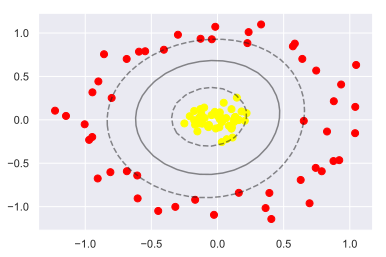

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

通过使用这个核函数化的支持向量机，我们找到了一条合适的非线性决策边界

## SVM优化:软化边界
处理数据重叠现象
<br>它允许一些点位于边界线之内。边界线的硬度可以通过超参数进行控制，通常是 C。 如果 C 很大，边界就会很硬，数据点便不能在边界内“生存”;如果 C 比较小，边界线比 较软，有一些数据点就可以穿越边界线。

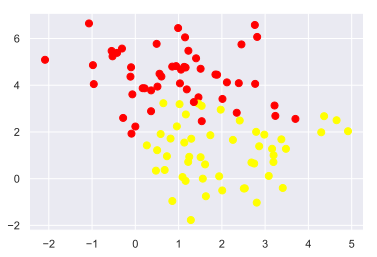

In [14]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

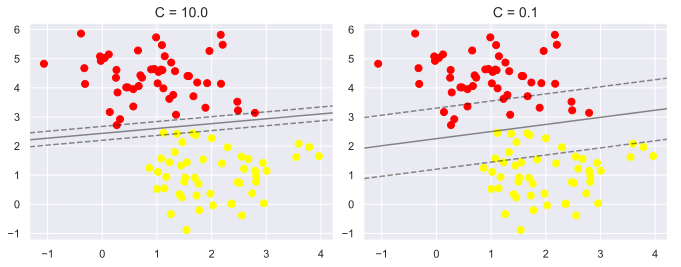

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)